In [100]:
"""
In this notebook , I try to run the samples I saw on internet
on a set i know.
I will create a stationary and non-stationary datasets,
and check the results of ARIMA and differences.
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

def plot_series(serie,label):
  plt.plot(serie)
  plt.ylabel(label)
  plt.show()


#Yt = α + βt + εt
def deterministic_trend2(begin,variance,sample_size,drift,trend):
  items = []
  x = begin
  for i in range(sample_size):
    noise = (np.random.randint(variance * -3,variance * 3, size=1)/10)[0]
    x =  i * trend + noise + drift
    items.append(x)
  return np.array(items)

def gen_stationary_data(begin,variance,sample_size,drift):
  items = []
  x = begin
  x_before = 10
  for i in range(sample_size):
    noise = (np.random.randint(variance * -3,variance * 3, size=1)/10)[0]
    x =  x_before * np.random.random() + noise + drift
    x_before = x
    items.append(x)
  return np.array(items)



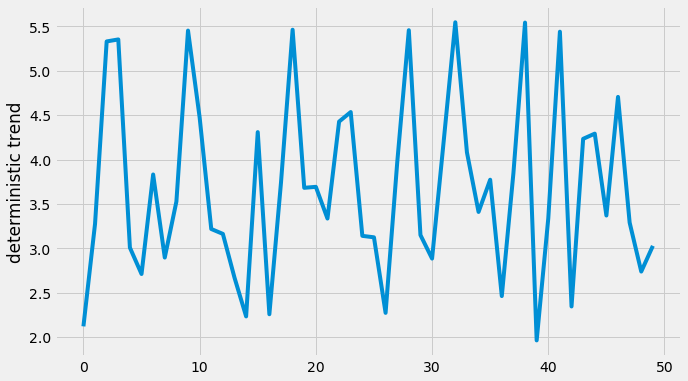

In [101]:
sample_size = 50
deterministic_trend_set = gen_stationary_data(begin=144,variance=1,sample_size=sample_size,drift=2)
plot_series(deterministic_trend_set,"deterministic trend")

In [102]:
data = pd.DataFrame(deterministic_trend_set,columns=["Price"])
data.head(5)

,Price
0,2.119573
1,3.275228
2,5.330684
3,5.353245
4,3.006917


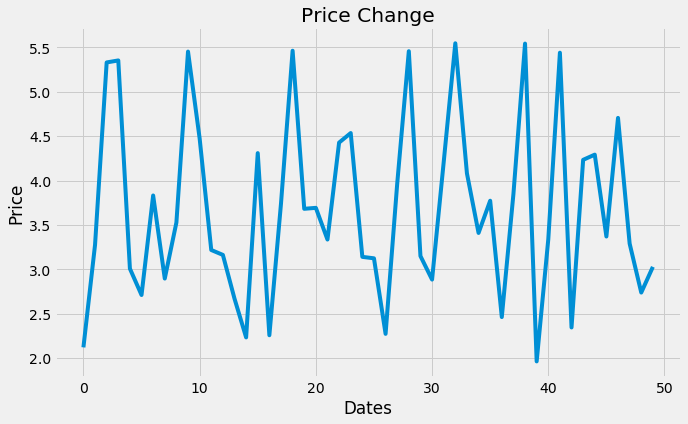

In [106]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
#plt.plot(data['Close'])
plt.plot(data['Price'])
plt.title('Price Change')
plt.show()

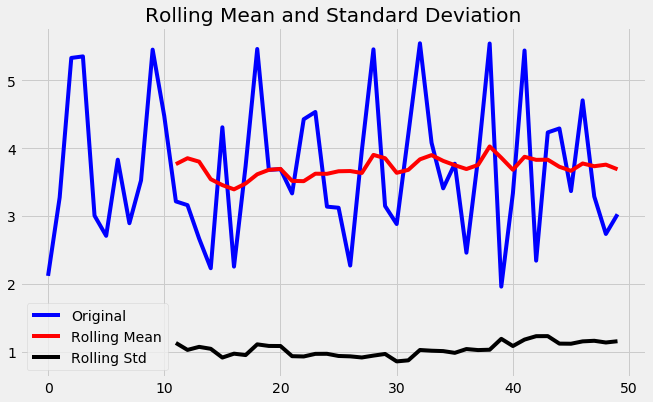

Results of dickey fuller test
Test Statistics                -3.839799
p-value                         0.002525
No. of lags used                7.000000
Number of observations used    42.000000
critical value (1%)            -3.596636
critical value (5%)            -2.933297
critical value (10%)           -2.604991
dtype: float64


In [105]:
#Yt = αYt-1
#Null Hypothesis (H0): alpha=1
#A Dickey-Fuller test is a unit root test that tests the mull hypothesis that α=1 in 
#the following model equation. alpha is the coefficient of the first lag on Y.
#The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher 
#than any of the critical values.
#no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

#If both mean and standard deviation are flat lines(constant mean and constant variance),
"the series becomes stationary.

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data)

<Figure size 720x432 with 0 Axes>

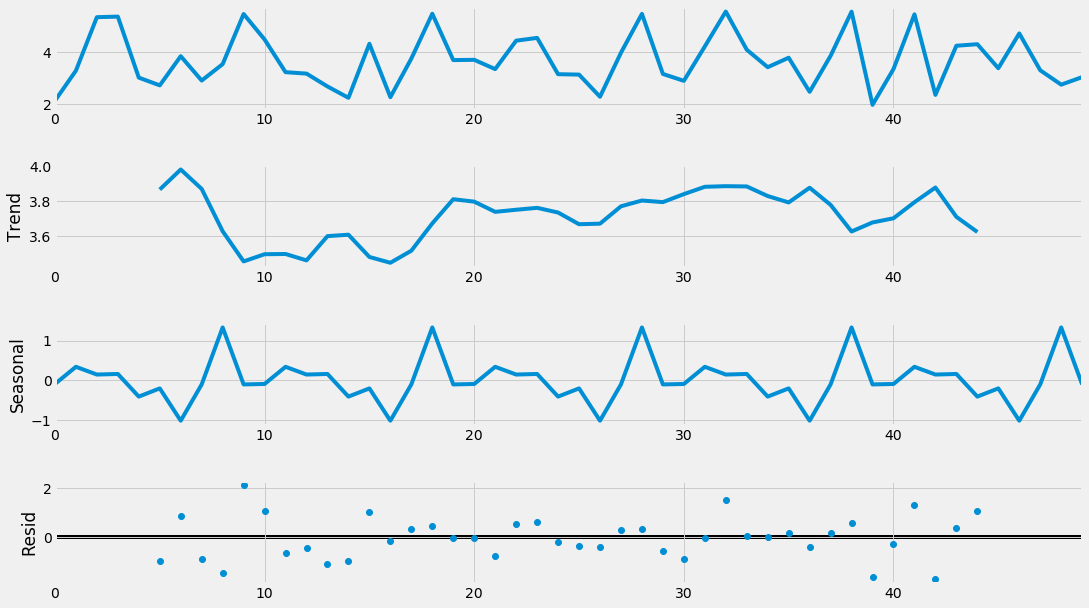

In [107]:
result = seasonal_decompose(data,  model='additive',freq = 10)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


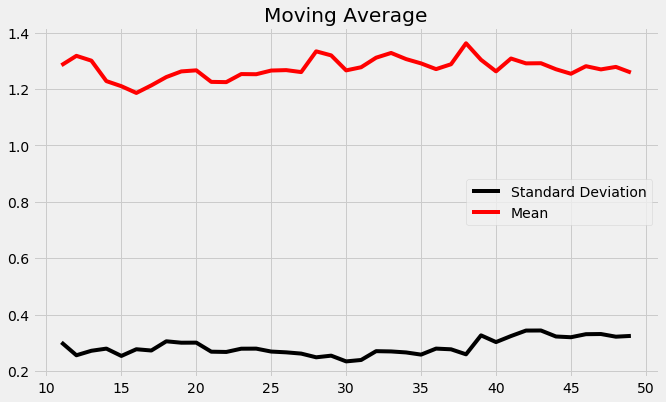

In [113]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

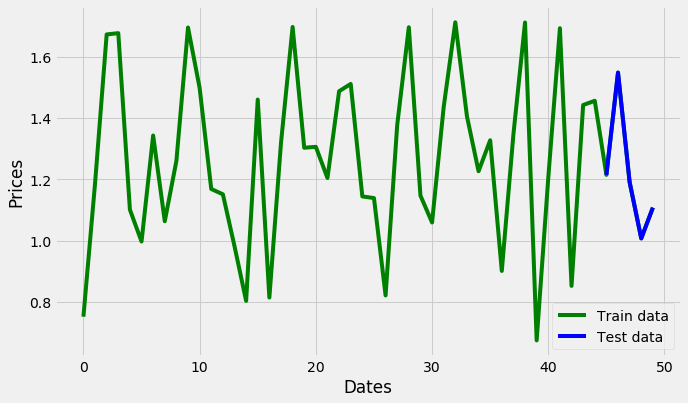

In [115]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [116]:
model_autoARIMA = auto_arima(train_data.dropna(), start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=15.989, BIC=19.465, Time=0.030 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=17.601, BIC=22.814, Time=0.108 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=17.023, BIC=22.236, Time=0.026 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=143.675, BIC=145.412, Time=0.004 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=15.773, BIC=22.723, Time=0.095 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=10.643, BIC=19.331, Time=0.178 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=14.744, BIC=21.695, Time=0.133 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=12.486, BIC=22.912, Time=0.307 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=12.004, BIC=22.430, Time=0.317 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=10.038, BIC=18.726, Time=0.200 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=8.047, BIC=14.997, Time=0

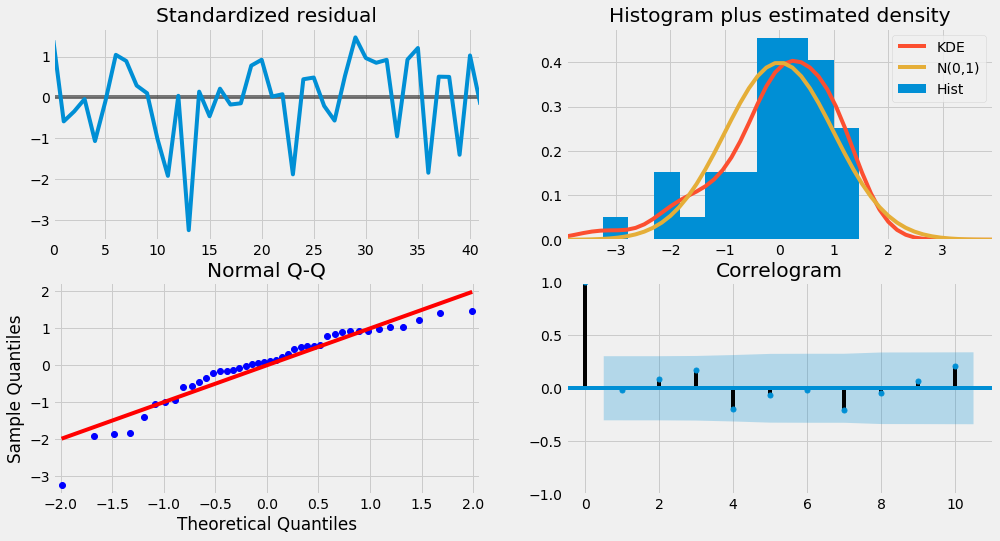

In [117]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [118]:
model = ARIMA(train_data.dropna(), order=(0, 0, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                   42
Model:                     ARMA(0, 2)   Log Likelihood                  -0.286
Method:                       css-mle   S.D. of innovations              0.233
Date:                Sat, 09 May 2020   AIC                              8.571
Time:                        22:39:43   BIC                             15.522
Sample:                             0   HQIC                            11.119
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2743      0.005    249.969      0.000       1.264       1.284
ma.L1.Price    -0.1619        nan        nan        nan         nan         nan
ma.L2.Price    -0.8381        nan        nan    

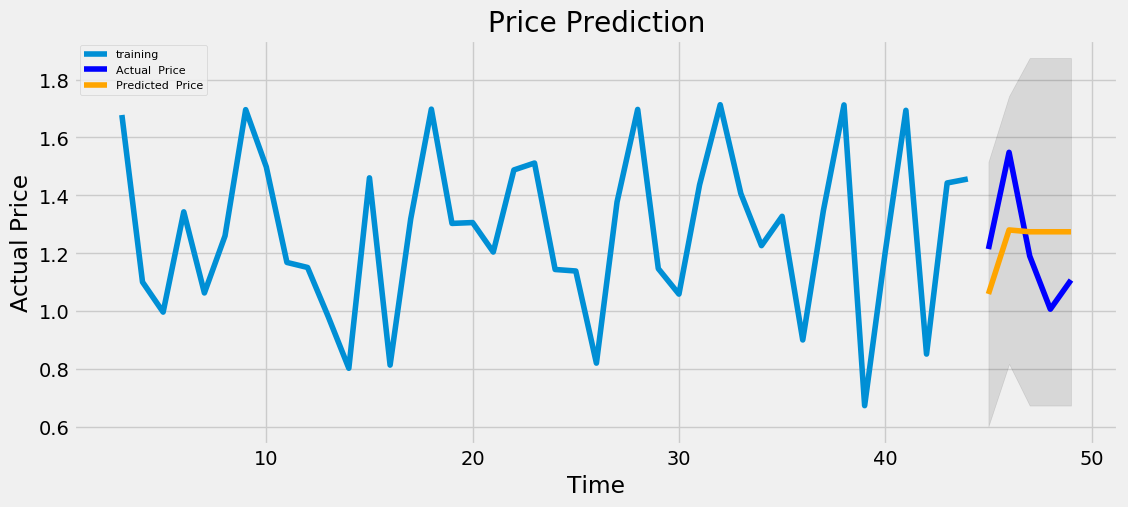

In [121]:
# Forecast
fc, se, conf = fitted.forecast(5, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual  Price')
plt.plot(fc_series, color = 'orange',label='Predicted  Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

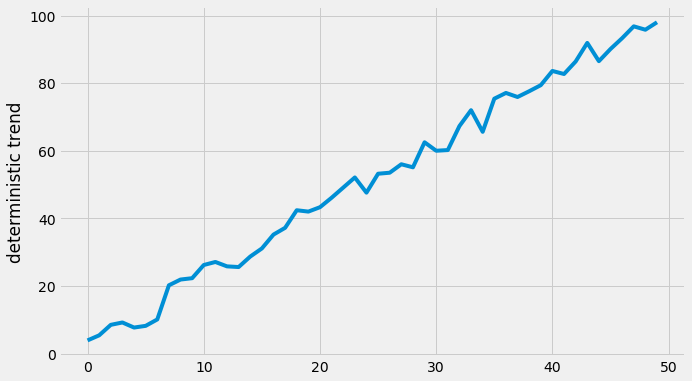

In [122]:
sample_size = 50
deterministic_trend_set = deterministic_trend2(begin=144,variance=15,sample_size=sample_size,drift=2,trend =2)
plot_series(deterministic_trend_set,"deterministic trend")

In [123]:
data = pd.DataFrame(deterministic_trend_set,columns=["Price"])
data.head(5)

,Price
0,3.9
1,5.4
2,8.5
3,9.2
4,7.7


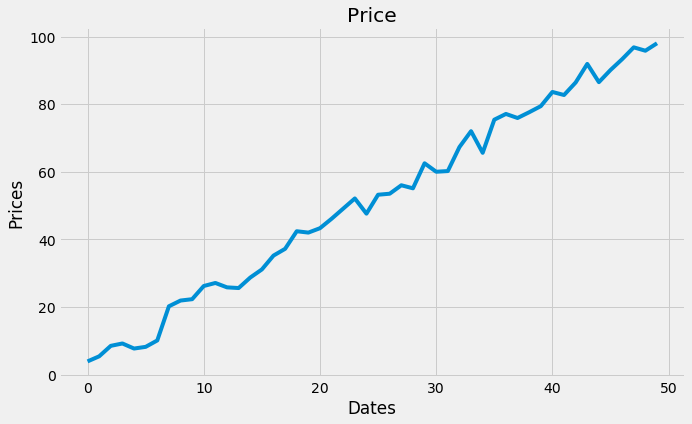

In [124]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.plot(data['Close'])
plt.plot(data['Price'])
plt.title('Price')
plt.show()

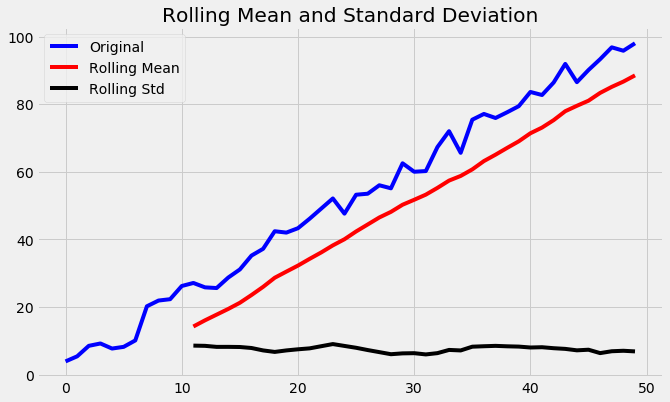

Results of dickey fuller test
Test Statistics                -0.933001
p-value                         0.776910
No. of lags used                7.000000
Number of observations used    42.000000
critical value (1%)            -3.596636
critical value (5%)            -2.933297
critical value (10%)           -2.604991
dtype: float64


In [126]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data)

<Figure size 720x432 with 0 Axes>

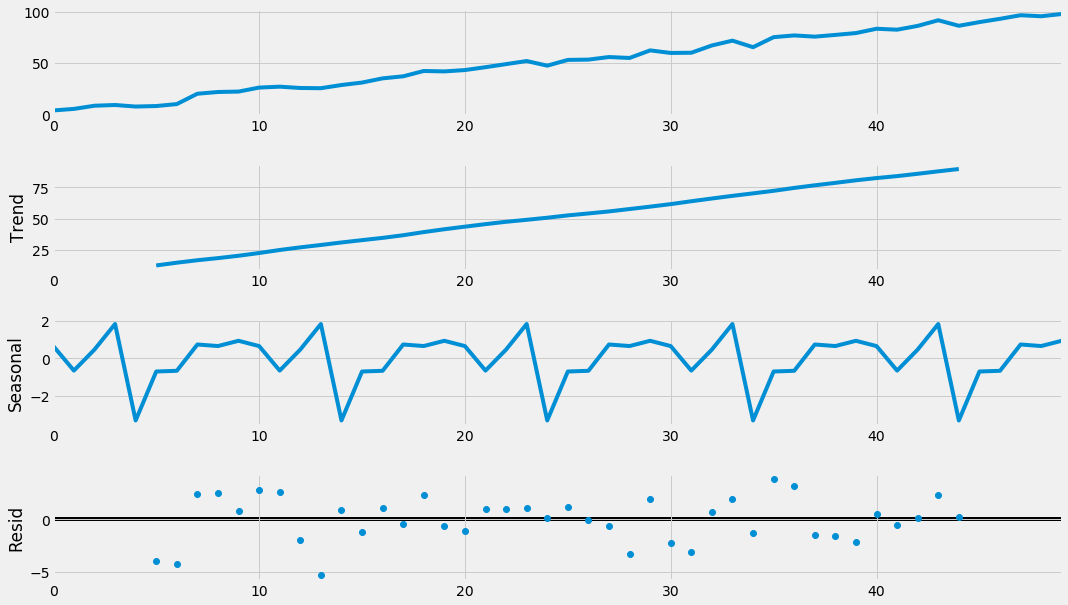

In [127]:
result = seasonal_decompose(data,  model='additive',freq = 10)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


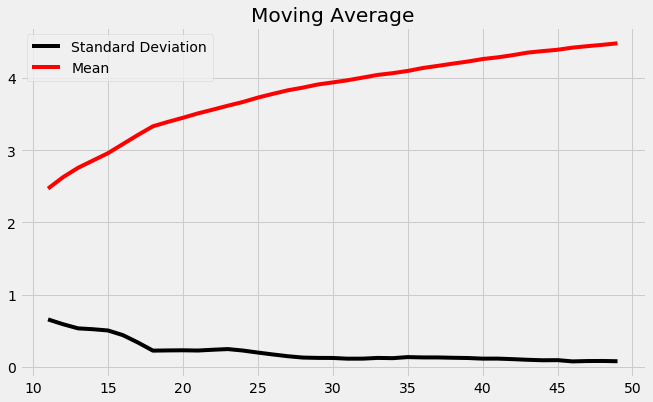

In [128]:


from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()



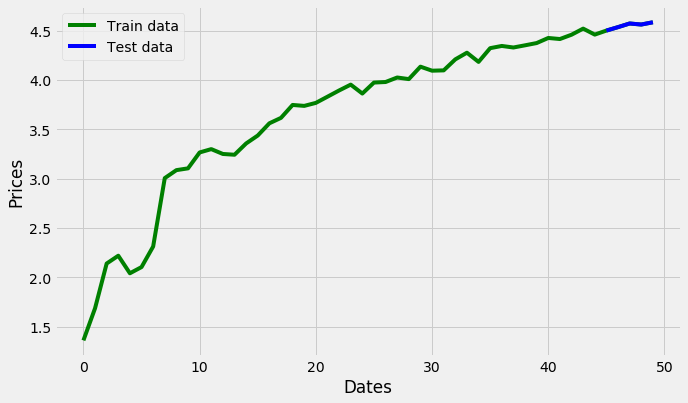

In [129]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [130]:
model_autoARIMA = auto_arima(train_data.dropna(), start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=88.404, BIC=91.879, Time=0.026 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-38.188, BIC=-32.975, Time=0.091 seconds
Near non-invertible roots for order (1, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=42.566, BIC=47.779, Time=0.062 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=233.081, BIC=234.819, Time=0.008 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-39.659, BIC=-32.708, Time=0.142 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-34.550, BIC=-25.862, Time=0.167 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=-38.138, BIC=-29.450, Time=0.160 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=11.881, BIC=18.832, Time=0.085 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=-40.213, BIC=-33.262, Time=0.217 se

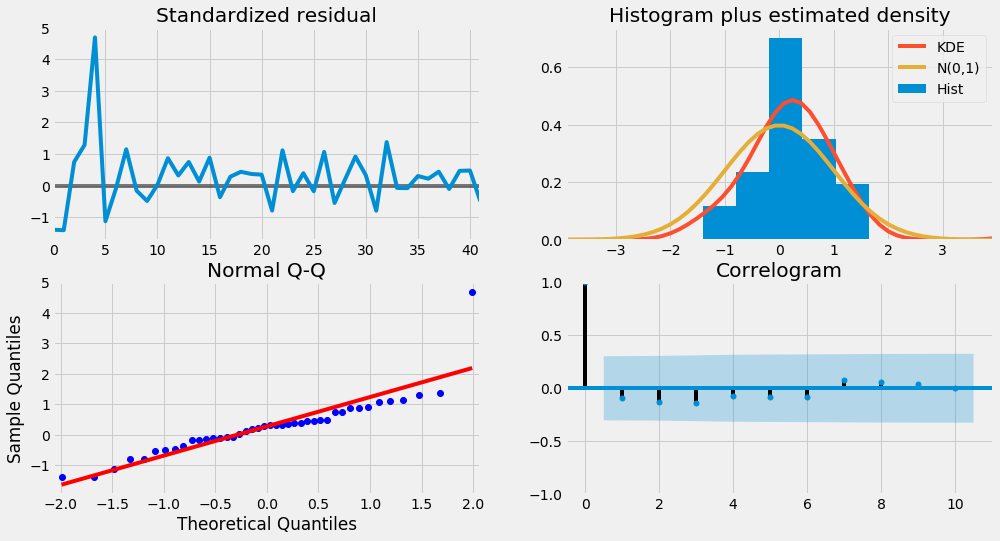

In [131]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [133]:
model = ARIMA(train_data.dropna(), order=(2, 0,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                   42
Model:                     ARMA(2, 0)   Log Likelihood                  24.107
Method:                       css-mle   S.D. of innovations              0.130
Date:                Sat, 09 May 2020   AIC                            -40.213
Time:                        22:42:31   BIC                            -33.263
Sample:                             0   HQIC                           -37.665
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4843      0.762      4.570      0.000       1.990       4.979
ar.L1.Price     1.3016      0.151      8.608      0.000       1.005       1.598
ar.L2.Price    -0.3167      0.156     -2.033    

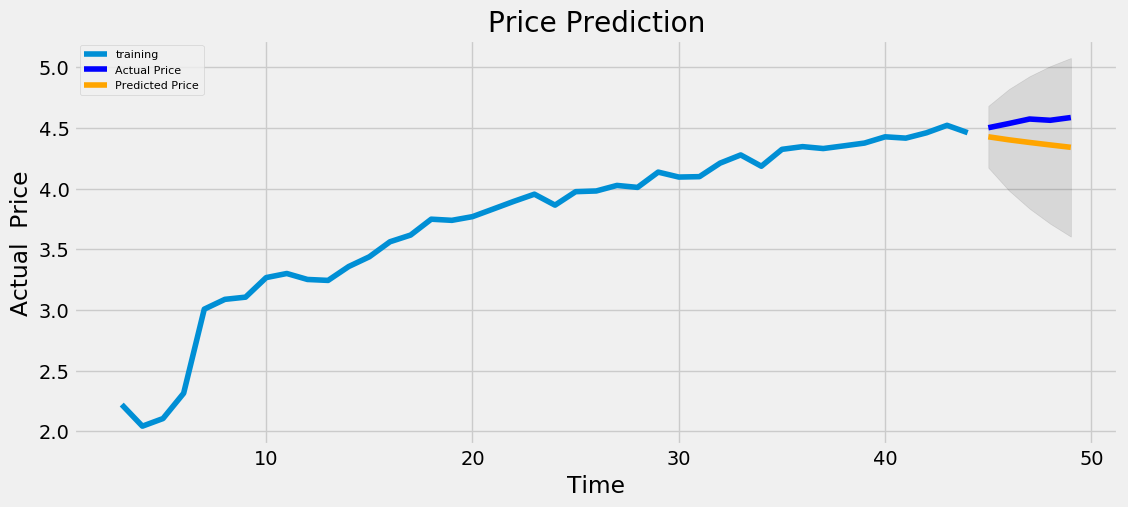

In [135]:
# Forecast
fc, se, conf = fitted.forecast(5, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Price')
plt.plot(fc_series, color = 'orange',label='Predicted Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual  Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [137]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))


MSE: 0.03249333576674063
MAE: 0.17017528447362978
RMSE: 0.1802590795681056
